In [1]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%aimport helpers
%autoreload 1

In [3]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import time

from helpers import show_model
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution, NormalDistribution

We consider a toy example with n=4 hidden states, whose outputs are univariate Gaussians, $\mathcal{N}(\mu,\sigma_i^2)$, with $\mathbf{A}$ and $\theta$ given by 

\begin{equation*}
\mathbf{A} =  \begin{matrix}
0.7 &  0.0 & 0.2 & 0.5 \\
0.2 &  0.6 & 0.2 & 0.0 \\
0.1 &  0.2 & 0.6 & 0.0 \\
0.0 &  0.2 & 0.0 & 0.5 \\
\end{matrix}
\end{equation*}

$f_{\theta_1} = \mathcal{N}(-4,4)$, $\quad $ $f_{\theta_2} = \mathcal{N}(0,1)$,$\quad $  $f_{\theta_3} = \mathcal{N}(2,36)$,$\quad $  $f_{\theta_4} = \mathcal{N}(4,1)$

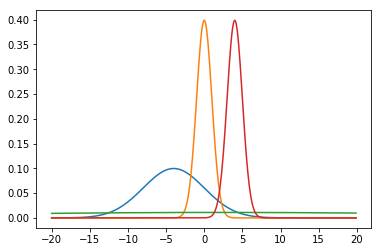

In [4]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
theta_1 = norm(loc = -4., scale = 4.0)
theta_2 = norm(loc = 0, scale = 1.0)
theta_3 = norm(loc = 2, scale = 36.0)
theta_4 = norm(loc = 4., scale = 1)
x = np.arange(-20, 20, .1)
plt.plot(x, theta_1.pdf(x), x, theta_2.pdf(x), x, theta_3.pdf(x), x, theta_4.pdf(x))

In [5]:
gt_model = HiddenMarkovModel(name = "Toy model")

# emission probability distributions
theta_dists = [NormalDistribution(-4, 4), NormalDistribution(0, 1), NormalDistribution(2, 36),NormalDistribution(4,1)]
trans_mat = np.array([[0.7, 0.0, 0.2, 0.5],
                      [0.2, 0.6, 0.2, 0.0],
                      [0.1, 0.2, 0.6, 0.0],
                      [0.0, 0.2, 0.0, 0.5],
                     ]).transpose()
# starts = np.array([1.0, 0.0, 0.0, 0.0])
starts = np.array([0.25, 0.25, 0.25, 0.25])
ends = np.array([0.0, 0.0 ,0.0, 0.0])

gt_model = HiddenMarkovModel.from_matrix(trans_mat, theta_dists, starts, ends)

In [37]:
seq_length = 20
num_samples = 200
keep_path = False
random_seed = 2
t = time.time()
samples = gt_model.sample(n = num_samples, length = seq_length, path = keep_path, random_state = 1)

elapsed = time.time() - t
print("Elapsed time is: ", elapsed, "sec")

Elapsed time is:  0.044738054275512695 sec


In [11]:

samples + np.random.randn(20)

array([[-1.06747614e-02,  4.90083472e+00,  5.50300160e+00, ...,
        -1.37695893e+01, -3.87470996e+01,  1.59262542e+01],
       [ 2.51114146e+00,  2.99940079e+00,  6.76315611e-01, ...,
         4.54419762e+00, -4.13658130e+00,  1.46366092e+00],
       [ 1.90475966e+00, -3.70925489e+00, -2.52676325e+00, ...,
         2.06264513e+01, -5.63307284e+00, -9.35885348e-01],
       ...,
       [-6.17412508e+00, -5.65943088e+00, -1.57131211e+00, ...,
        -2.42955360e+01, -2.55408376e+01,  8.09713660e+01],
       [ 2.06788228e+00,  4.46227206e+00, -5.03979746e+00, ...,
        -2.74728906e+00, -1.16281035e+01, -5.07728064e-01],
       [-6.91610675e+00,  1.45878218e+00,  3.18464129e+00, ...,
         2.22889569e-01,  1.01642128e+00,  3.07232173e+00]])

In [15]:
fitted_model = HiddenMarkovModel(name = "Fitted Toy model")
t = time.time()
fitted_model = fitted_model.from_samples(NormalDistribution, n_components=4, X=samples)
elapsed = time.time() - t
print("Elapsed time is: ", elapsed, " sec")

Elapsed time is:  19.526983976364136  sec


In [22]:
fitted_model_with_noise = HiddenMarkovModel(name = "Fitted Toy model with noise")
t = time.time()
samples_Gaussian_noise = samples + 0.05*np.random.randn(20)
fitted_model_with_noise = fitted_model_with_noise.from_samples(NormalDistribution, n_components=4, X=samples_Gaussian_noise)
elapsed = time.time() - t
print("Elapsed time is: ", elapsed, " sec")

Elapsed time is:  24.402047157287598  sec


In [53]:
import pandas as pd
fitted_model_with_filling = HiddenMarkovModel(name = "Fitted Toy model with filling")
missing_prob = 0.1
samples_filling = np.copy(samples)
for i, each_sample in enumerate(samples_filling):
    mask = np.random.choice([True, False], size=seq_length, p=[missing_prob, 1-missing_prob])
    if mask[0] is True:
        mask[0] = False
    each_sample[mask] = np.NaN
    # print(each_sample)
    df = pd.DataFrame(each_sample)
    df = df.fillna(method='ffill')
    samples_filling[i] = df.values.flatten()
t = time.time()
fitted_model_with_filling = fitted_model_with_filling.from_samples(NormalDistribution, n_components=4, X=samples_filling)
elapsed = time.time() - t
print("Elapsed time is: ", elapsed, " sec")

Elapsed time is:  10.341312170028687  sec


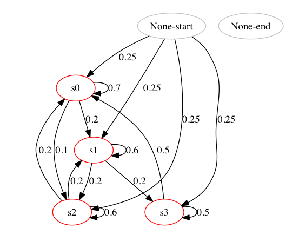

In [27]:
gt_model.plot()

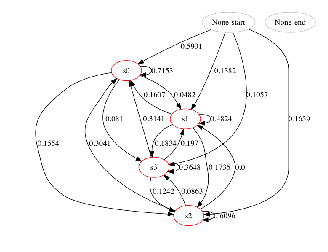

In [63]:
fitted_model.plot()

In [54]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})
# there are six edges for each state
estimated_transition_matrix = fitted_model.dense_transition_matrix()
true_transition_matrix = gt_model.dense_transition_matrix()
estimated_with_noise_transition_matrix = fitted_model_with_noise.dense_transition_matrix()

estimated_with_filling = fitted_model_with_filling.dense_transition_matrix()
# print(estimated_transition_matrix)
# print(true_transition_matrix)

# Since the fitted model have no knowledge of state, 
# the learned transition matrix is a permutation of true transition matrix
import numpy as np
from itertools import permutations
from numpy import linalg as LA
num_states = 4
#gt_mat = np.random.rand(num_states+2, num_states+2)
# fitted_mat = np.random.rand(num_states+2, num_states+2)
gt_mat = true_transition_matrix
# fitted_mat = estimated_transition_matrix
# fitted_mat = estimated_with_noise_transition_matrix
fitted_mat = estimated_with_filling
gt_trans = gt_mat[0:num_states, 0:num_states]
fitted_trans = fitted_mat[0:num_states, 0:num_states]
perms = list(permutations(range(0, num_states))) # this serve as index of permutation
min_norm = np.inf
best_perm_row = None
best_perm_col = None 
for idx_col in perms:
    for idx_row in perms:
        curr_norm = LA.norm(gt_trans-fitted_trans[idx_row,:][:,idx_col], ord = 'fro')
        # print(curr_norm, idx_row, idx_col)
        if curr_norm < min_norm:
            best_perm_row = idx_row
            best_perm_col = idx_col
            min_norm = curr_norm


print(gt_trans)
#print(fitted_trans)
#print(best_perm_row)
#print(best_perm_col)
#print(fitted_trans[[0,2,1,3],:][:,[0,2,1,3]])
print(fitted_trans[best_perm_row,:][:,best_perm_col])
print(LA.norm(gt_trans - fitted_trans[best_perm_row,:][:,best_perm_col]))

[[0.70 0.20 0.10 0.00]
 [0.00 0.60 0.20 0.20]
 [0.20 0.20 0.60 0.00]
 [0.50 0.00 0.00 0.50]]
[[0.74 0.04 0.09 0.13]
 [0.23 0.42 0.16 0.19]
 [0.26 0.12 0.50 0.12]
 [0.27 0.00 0.07 0.66]]
0.5020737267166756


In [29]:
def permutate_trans_matrix(gt_mat, fitted_mat, num_states):
    gt_trans = gt_mat[0:num_states, 0:num_states]
    fitted_trans = fitted_mat[0:num_states, 0:num_states]
    perms = list(permutations(range(0, num_states))) # this serve as index of permutation
    min_norm = np.inf
    best_perm_row = None
    best_perm_col = None 
    for idx_col in perms:
        for idx_row in perms:
            curr_norm = LA.norm(gt_trans-fitted_trans[idx_row,:][:,idx_col], ord = 'fro')
            # print(curr_norm, idx_row, idx_col)
            if curr_norm < min_norm:
                best_perm_row = idx_row
                best_perm_col = idx_col
                min_norm = curr_norm
    return min_norm, best_perm_row, best_perm_col


In [31]:
theta_dists = [NormalDistribution(-4, 4), NormalDistribution(0, 1), NormalDistribution(2, 36),NormalDistribution(4,1)]
trans_mat = np.array([[0.7, 0.0, 0.2, 0.5],
                      [0.2, 0.6, 0.2, 0.0],
                      [0.1, 0.2, 0.6, 0.0],
                      [0.0, 0.2, 0.0, 0.5],
                     ]).transpose()
# starts = np.array([1.0, 0.0, 0.0, 0.0])
starts = np.array([0.25, 0.25, 0.25, 0.25])
ends = np.array([0.0, 0.0 ,0.0, 0.0])
num_states = 4
gt_model = HiddenMarkovModel.from_matrix(trans_mat, theta_dists, starts, ends)
fitted_model = HiddenMarkovModel(name = "Fitted Toy model")
# sampling parameter
seq_length = 20
num_samples = 200
keep_path = False
sigma = np.array([0.01, 0.05, 0.07, 0.1, 0.2])

num_runs = 5
error = np.zeros(num_runs)
error_noise1 = np.zeros((num_runs, sigma.shape[0]))
for run in range(num_runs):
    print("running" , run, '/', num_runs);
    random_seed = time.time()
    samples = gt_model.sample(n = num_samples, length = seq_length, path = keep_path, random_state = 1)
    fitted_model = fitted_model.from_samples(NormalDistribution, n_components=4, X=samples)
    [min_norm, best_perm_row, best_perm_col]=permutate_trans_matrix(gt_model.dense_transition_matrix(), fitted_model.dense_transition_matrix(), num_states)
    error[run] = min_norm
    for i, s in enumerate(sigma):
        fitted_model_with_noise = HiddenMarkovModel(name = "Fitted Toy model with noise")
        noisy_samples = samples + s * np.random.randn(seq_length)
        fitted_model_with_noise = fitted_model_with_noise.from_samples(NormalDistribution, n_components=4, X=noisy_samples)
        [min_norm, best_perm_row, best_perm_col]=permutate_trans_matrix(gt_model.dense_transition_matrix(), fitted_model.dense_transition_matrix(), num_states)
        error_noise1[run, i] = min_norm
print(np.mean(error))  
print(error_noise1)

running 0 / 5
running 1 / 5
running 2 / 5
running 3 / 5
running 4 / 5
0.43221769273744826
[[0.49 0.49 0.49 0.49 0.49]
 [0.49 0.49 0.49 0.49 0.49]
 [0.39 0.39 0.39 0.39 0.39]
 [0.39 0.39 0.39 0.39 0.39]
 [0.39 0.39 0.39 0.39 0.39]]


Lets try with different noise model.
In first noise model, We apply the same Guassian noise to all observations.
In second noise model, we encountered missing values in the sequence. The assumption is that the data is missing at random and the model parameters corresponding to the missing data are separate from the model parameters of the observed data. Then we fill the missing value with previous non-missing value.

In [33]:
import numpy as np
def _rolling_window(a, window):
    """
    [True, True, False, True, False], 2 ->
    [
        [True,  True],
        [True, False],
        [False, True],
        [True, False],
    ]
    """
    # https://stackoverflow.com/a/6811241
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

_rolling_window(np.array([True, True, False, True, False]), 2)

array([[ True,  True],
       [ True, False],
       [False,  True],
       [ True, False]])